In [18]:
import networkx as nx
import igraph
#import community
import copy
import numpy as np
%matplotlib inline
#from infomap import infomap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from collections import Counter
import math
from itertools import combinations
from itertools import product
from random import shuffle
import pandas as pd

In [12]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    infomapWrapper = infomap.Infomap("--two-level --silent")

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges():
        infomapWrapper.addLink(*e)

    print("Find communities with Infomap...")
    infomapWrapper.run();

    tree = infomapWrapper.tree

    print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

    communities = {}
    for node in tree.leafIter():
        communities[node.originalLeafIndex] = node.moduleIndex()

    nx.set_node_attributes(G, name='community', values=communities)
    return tree.numTopModules()

# lo saqué de acá:
# https://github.com/mapequation/infomap/blob/master/examples/python/infomap-examples.ipynb

In [2]:
# Funcion que paso Agus
def clusterize(nx_Graph, method="infomap"):
    """
    Calcula el agrupamiento en comunidades de un grafo.
    
    In:
        nx_Graph: grafo de networkx
        method: metodo de clustering, puede ser: "infomap", "fastgreedy", "eigenvector", "louvain", "edge_betweenness","label_prop", "walktrap", ""
        
    Out:
        labels_dict: diccionario de nodo : a label al cluster al que pertenece.
    """
    if method == "edge_betweenness":
        nx_Graph = max(nx.connected_component_subgraphs(nx_Graph), key=len)#se queda con la componente más grande.
        print("AVISO: restringiendo a la componente connexa más grade. De otro modo falla el algoritmo de detección de comunidades edge_betweenness.")
    
    isdirected = nx.is_directed(nx_Graph)
    np_adj_list = nx.to_numpy_matrix(nx_Graph)
    g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
    if method=="infomap":
        labels = g.community_infomap(edge_weights="weight").membership
    if method=="label_prop":
        labels = g.community_label_propagation(weights="weight").membership
    if method=="fastgreedy":
        labels = g.community_fastgreedy(weights="weight").as_clustering().membership
    if method=="eigenvector":
        labels = g.community_leading_eigenvector(weights="weight").membership
    if method=="louvain":
        labels = g.community_multilevel(weights="weight").membership
    if method=="edge_betweenness":
        labels = g.community_edge_betweenness(weights="weight", directed=isdirected).as_clustering().membership
    if method=="walktrap":
        labels = g.community_walktrap(weights="weight").as_clustering().membership
    
    label_dict = {node:label for node,label in zip(nx_Graph.nodes(), labels)}
    return label_dict

In [3]:
# Varias de visualizaciones
def drawNetwork(G):
    # position map
    pos = nx.spring_layout(G)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    # print(communities)
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 
                                      'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 
                                     'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(nx.get_node_attributes(G, 'community')[n])
        )

    plt.axis('off')
    plt.show()
    
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos


def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

# Otra variante
def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [15]:
def silhouette(red, comus):
    numcomus = len(set(comus.values()))
    nodosxcomu = [list(comus.values()).count(i) for i in set(comus.values())]
    d = nx.shortest_path(red)
    # Distancia media de cada nodo a cada comunidad.
    avgd = dict([(nodo, [0]*numcomus) for nodo in red.nodes()])
    
    for i, nodoi in enumerate(red.nodes()):
        for j,nodoj in enumerate(red.nodes()):
            if (j>i):
                avgd[nodoi][comus[nodoj]] += (len(d[nodoi][nodoj])-1)/(nodosxcomu[comus[nodoj]]-(comus[nodoi]==comus[nodoj]))
                avgd[nodoj][comus[nodoi]] += (len(d[nodoj][nodoi])-1)/(nodosxcomu[comus[nodoi]]-(comus[nodoj]==comus[nodoi]))
    
    # Estas son las tiras a, b y s que aparecen en el paper.
    # a = distancia media de cada nodo a todos los nodos de su comunidad.
    # b = mínima de avgd (sin contar a su propia comunidad).
    # s = silhouette de cada nodo.
    # avgs = silhouette promedio de la partición entera.
    a = dict([(nodo,avgd[nodo][comus[nodo]]) for nodo in red.nodes()])
    b = dict([(nodo,min(avgd[nodo][:comus[nodo]]+avgd[nodo][comus[nodo]+1:])) for nodo in red.nodes()])
    s = dict([(nodo,(b[nodo]-a[nodo])/max(b[nodo],a[nodo])) for nodo in red.nodes()])
    avgs = np.mean(list(s.values()))
    
    return avgs

In [16]:
def modularidad(red, comus):
    numcomus = len(set(comus.values()))
    #nodosxcomu = [list(comus.values()).count(i) for i in set(comus.values())]
    #nodosxcomu = dict([(com, nodo) for nodo,com in comus])
    M = 0
    L = red.number_of_edges()
    Lc = [0]*numcomus
    kc = [0]*numcomus
    
    for edge in red.edges():
        if comus[edge[0]] == comus[edge[1]]:
            Lc[comus[edge[0]]] += 1
    
    for grado in red.degree():
        kc[comus[grado[0]]] += grado[1]
    
    for c in range(0,numcomus):
        M += Lc[c]/L - (kc[c]/(2*L))**2
    return M

In [17]:
def mod_distrib(red, comus, n):
    #print (r.degree())
    L = red.number_of_edges()
    M = [0]*n
    for i in range(n):
        nx.double_edge_swap(red,10*L,1000*L)
        M[i] = modularidad(red,comus)
    return ((np.mean(M),np.std(M,ddof=1)))

### Cargamos los datos y el sexo

In [8]:
red_delf = nx.read_gml('./Datos/dolphins.gml')
gen_delf = open('./Datos/dolphinsGender.txt').readlines()
    
sex_delf = []   
for i in range(len(gen_delf)):
    a = gen_delf[i].rstrip('\n').split('\t')
    sex_delf.append(a)

def atributoNodos(r, alist, atributo):

    for idx, nodo in enumerate(np.array(alist).transpose()[0]):
        r.nodes[nodo][atributo] = np.array(alist).transpose()[1][idx]

atributoNodos(red_delf, sex_delf, 'sexo')

In [19]:
# Pequeña observación: Hay delfines de los cuales no conocemos el sexo
# tenemos que decidir que vamos a hacer con eso --> borrarlos?
# ¿Considerarlo como otra categoría?

### Ejercicio 1 - Cálculo de clusters

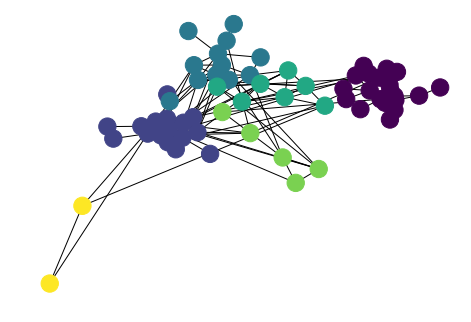

In [10]:
comus_infomap = clusterize(red_delf, "infomap") #List
nx.set_node_attributes(red_delf, name='community', values=comus_infomap)
#drawNetwork(red_delf)

pos = community_layout(red_delf,comus_infomap)
nx.draw(red_delf, pos, node_color=list(comus_infomap.values()))
plt.show()

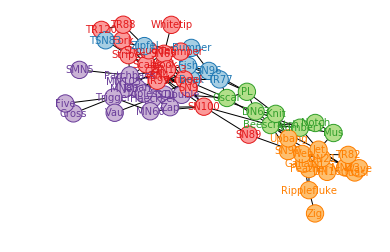

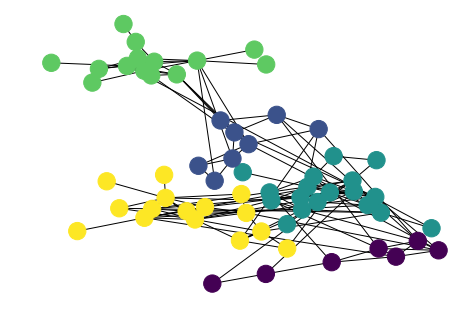

In [11]:
comus_louvain = clusterize(red_delf, "louvain") #List
nx.set_node_attributes(red_delf, name='community', values=comus_louvain)
drawNetwork(red_delf)

pos = community_layout(red_delf,comus_louvain)
nx.draw(red_delf, pos, node_color=list(comus_louvain.values()))
plt.show()

AVISO: restringiendo a la componente connexa más grade. De otro modo falla el algoritmo de detección de comunidades edge_betweenness.


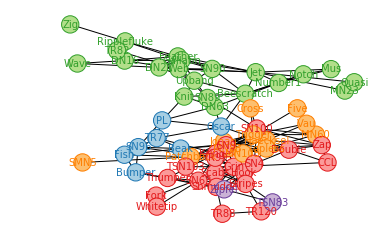

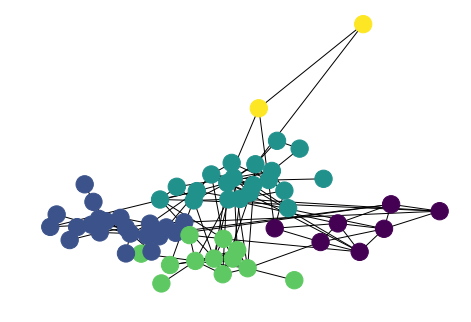

In [15]:
comus_edgeb = clusterize(red_delf, "edge_betweenness") #List
nx.set_node_attributes(red_delf, name='community', values=comus_edgeb)
drawNetwork(red_delf)

pos = community_layout(red_delf,comus_edgeb)
nx.draw(red_delf, pos, node_color=list(comus_edgeb.values()))
plt.show()

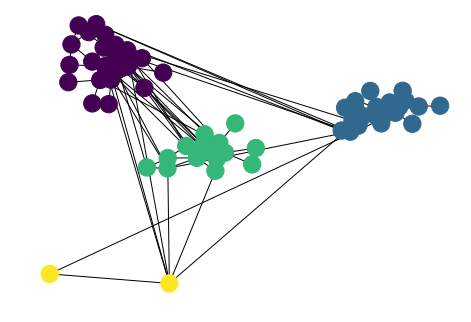

In [16]:
comus_fg = clusterize(red_delf, "fastgreedy") #List
nx.set_node_attributes(red_delf, name='community', values=comus_fg)
#drawNetwork(red_delf)

pos = community_layout(red_delf,comus_fg)
nx.draw(red_delf, pos, node_color=list(comus_fg.values()))
plt.show()

### Ejercicio 2

In [132]:
print("Silhouette Infomap:",silhouette(red_delf,comus_infomap))
print("Silhouette Louvain:",silhouette(red_delf,comus_louvain))
print("Silhouette Edge Betweenness:",silhouette(red_delf,comus_edgeb))
print("Silhouette Fast Greedy:",silhouette(red_delf,comus_fg))

Silhouette Infomap: 0.23760221553692212
Silhouette Louvain: 0.23390984445073904
Silhouette Edge Betweenness: 0.28762733242788757
Silhouette Fast Greedy: 0.13795463279675574


In [131]:
print("Modularidad Infomap:",modularidad(red_delf,comus_infomap))
print("Modularidad Louvain:",modularidad(red_delf,comus_louvain))
print("Modularidad Edge Betweenness:",modularidad(red_delf,comus_edgeb))
print("Modularidad Fast Greedy:",modularidad(red_delf,comus_fg))

Modularidad Infomap: 0.5189470353229697
Modularidad Louvain: 0.5185317036509632
Modularidad Edge Betweenness: 0.5193821446936434
Modularidad Fast Greedy: 0.4954906847039278


In [7]:
red_delf_randomizada = red_delf.copy()
dist_infomap = mod_distrib(red_delf_randomizada,comus_infomap,10)
dist_louvain = mod_distrib(red_delf_randomizada,comus_louvain,10)
dist_edgeb = mod_distrib(red_delf_randomizada,comus_edgeb,10)
dist_fg = mod_distrib(red_delf_randomizada,comus_fg,10)

print("Modularidad Infomap para red randomizada (media,std):",dist_infomap)
print("Modularidad Louvain para red randomizada:",dist_louvain)
print("Modularidad Edge Betweenness para red randomizada:",dist_edgeb)
print("Modularidad Fast Greedy para red randomizada:",dist_fg)

NameError: name 'red_delf' is not defined

### Ejercicio 3

In [22]:
# Funciones auxiliares

def poblacionComus(particion):
# IN: Una partición en forma de diccionario.
# OUT: Un diccionario donde las keys son las comunidades y los values son el
# número de miembros de cada comunidad.
    values = particion.values()
    return Counter(values)


def pares(listas):
    pares_set = set()
    for t in combinations(listas, 2):
        for par in product(*t):
            pares_set.add(frozenset(par))
    return pares_set


def intersect(l1, l2): 
# Intersección entre dos listas.
    l3 = [value for value in l1 if value in l2] 
    return l3

In [6]:
# Información Mutua

def informacionMutua(p1,p2):
# IN: Dos particiones, en forma de diccionarios.
# OUT: Información mutua normalizada.    
    
    # En estas líneas calculo las probabilidades, para cada partición, de que   
    # un nodo elegido al azar de la red pertenezca a una cierta comunidad. 
    # En las listas probs_p1 y probs_p2, están dichas probabilidades.
    probs_p1 = []
    probs_p2 = []
    prob_conj = []
    comus1 = poblacionComus(p1)
    comus2 = poblacionComus(p2)
    n = len(p1)
    
    for comu in sorted(comus1.keys()):
        prob = comus1[comu]/n
        probs_p1.append(prob)
    for comu in sorted(comus2.keys()):
        prob = comus2[comu]/n
        probs_p2.append(prob)
        
    # En estas lineas hago dos listas de listas. Cada lista, tiene adentro una
    # lista con los miembros de cada comunidad.    
    comus1_list = []
    comus2_list = []
    for comu in sorted(comus1.keys()):
        miembros_comu = []
        for nodo in p1.keys():
            if p1[nodo] == comu:
                miembros_comu.append(nodo)
        comus1_list.append(miembros_comu)
        
    for comu in sorted(comus2.keys()):
        miembros_comu = []
        for nodo in p2.keys():
            if p2[nodo] == comu:
                miembros_comu.append(nodo)
        comus2_list.append(miembros_comu)
    
    # En estas líneas calculo la probabilidad conjunta pij de que un dado nodo 
    # pertenezca a la comunidad i de la primera partición y a la comunidad j de
    # la segunda partición. Estas probabilidades están en la lista de listas 
    # (o también podemos llamarle Matriz de coaparición normalizada), prob_conj.
    for pobi_list in comus1_list:
        pij = []
        for pobj_list in comus2_list:
            pij.append(len(intersect(pobi_list,pobj_list))/n)
        prob_conj.append(pij)
    
    # En las líneas que quedan, hago el cálculo de la información mutua, y 
    # entropías de Shannon (me encanta decirlo) para devolver la información
    # mutua normalizada.
    I = 0
    for i in range(len(comus1.keys())):
        for j in range(len(comus2.keys())):
            if prob_conj[i][j] == 0:
                I += 0
            else:
                I += prob_conj[i][j]*math.log(prob_conj[i][j]/(probs_p1[i]*probs_p2[j]),2)
            
    H1 = 0
    for i in range(len(comus1.keys())):
        H1 += -probs_p1[i]*math.log(probs_p1[i],2)
        
    H2 = 0
    for i in range(len(comus2.keys())):
        H2 += -probs_p2[i]*math.log(probs_p2[i],2)
        
    return 2*I/(H1 + H2)

In [4]:
# Presición

def presicion(p1,p2): 
    comus1 = poblacionComus(p1)
    comus2 = poblacionComus(p2)
    comus1_list = []
    comus2_list = []
    n = len(p1)
    
    for comu in sorted(comus1.keys()):
        miembros_comu = []
        for nodo in p1.keys():
            if p1[nodo] == comu:
                miembros_comu.append(nodo)
        comus1_list.append(miembros_comu)
        
    for comu in sorted(comus2.keys()):
        miembros_comu = []
        for nodo in p2.keys():
            if p2[nodo] == comu:
                miembros_comu.append(nodo)
        comus2_list.append(miembros_comu)
        
    pares_comus1 = []    
    for comu in comus1_list:
        pares1 = set()
        for par in combinations(comu,2):
            pares1.add(frozenset(par))
        pares_comus1.append(pares1)
        
    a11 = 0
    a00 = 0
    for set_pares in pares_comus1:
        for comu in comus2_list:
            for par in combinations(comu,2):
                if set(par) in set_pares:
                    a11 += 1
                    
    np1 = pares(comus1_list)
    np2 = pares(comus2_list)
    
    for par1 in np1:
        if par1 in np2:
            a00 += 1
    
    return (a11 + a00)/(n*(n-1)/2)

In [27]:
particiones = ['Fast-greedy', 'Edge-betweenness', 'Infomap', 'Louvain']

tabla_infomutua = pd.DataFrame(np.nan, columns = particiones, index = particiones)
tabla_presicion = pd.DataFrame(np.nan, columns = particiones, index = particiones)

tabla_infomutua.loc['Fast-greedy']['Fast-greedy'] = informacionMutua(comus_fg, comus_fg)
tabla_infomutua.loc['Edge-betweenness']['Edge-betweenness'] = informacionMutua(comus_edgeb, comus_edgeb)
tabla_infomutua.loc['Infomap']['Infomap'] = informacionMutua(comus_infomap, comus_infomap)
tabla_infomutua.loc['Louvain']['Louvain'] = informacionMutua(comus_louvain, comus_louvain)
tabla_infomutua.loc['Louvain']['Fast-greedy'] = informacionMutua(comus_louvain, comus_fg)
tabla_infomutua.loc['Fast-greedy']['Louvain'] = informacionMutua(comus_fg, comus_louvain)
tabla_infomutua.loc['Louvain']['Edge-betweenness'] = informacionMutua(comus_louvain, comus_edgeb)
tabla_infomutua.loc['Edge-betweenness']['Louvain'] = informacionMutua(comus_edgeb, comus_louvain)
tabla_infomutua.loc['Louvain']['Infomap'] = informacionMutua(comus_louvain, comus_infomap)
tabla_infomutua.loc['Infomap']['Louvain'] = informacionMutua(comus_louvain, comus_infomap)
tabla_infomutua.loc['Edge-betweenness']['Fast-greedy'] = informacionMutua(comus_edgeb, comus_fg)
tabla_infomutua.loc['Fast-greedy']['Edge-betweenness'] = informacionMutua(comus_edgeb, comus_fg)
tabla_infomutua.loc['Edge-betweenness']['Infomap'] = informacionMutua(comus_edgeb, comus_infomap)
tabla_infomutua.loc['Infomap']['Edge-betweenness'] = informacionMutua(comus_edgeb, comus_infomap)
tabla_infomutua.loc['Fast-greedy']['Infomap'] = informacionMutua(comus_fg, comus_infomap)
tabla_infomutua.loc['Infomap']['Fast-greedy'] = informacionMutua(comus_fg, comus_infomap)

tabla_presicion.loc['Fast-greedy']['Fast-greedy'] = presicion(comus_fg, comus_fg)
tabla_presicion.loc['Edge-betweenness']['Edge-betweenness'] = presicion(comus_edgeb, comus_edgeb)
tabla_presicion.loc['Infomap']['Infomap'] = presicion(comus_infomap, comus_infomap)
tabla_presicion.loc['Louvain']['Louvain'] = presicion(comus_louvain, comus_louvain)
tabla_presicion.loc['Louvain']['Fast-greedy'] = presicion(comus_louvain, comus_fg)
tabla_presicion.loc['Fast-greedy']['Louvain'] = presicion(comus_fg, comus_louvain)
tabla_presicion.loc['Louvain']['Edge-betweenness'] = presicion(comus_louvain, comus_edgeb)
tabla_presicion.loc['Edge-betweenness']['Louvain'] = presicion(comus_edgeb, comus_louvain)
tabla_presicion.loc['Louvain']['Infomap'] = presicion(comus_louvain, comus_infomap)
tabla_presicion.loc['Infomap']['Louvain'] = presicion(comus_louvain, comus_infomap)
tabla_presicion.loc['Edge-betweenness']['Fast-greedy'] = presicion(comus_edgeb, comus_fg)
tabla_presicion.loc['Fast-greedy']['Edge-betweenness'] = presicion(comus_edgeb, comus_fg)
tabla_presicion.loc['Edge-betweenness']['Infomap'] = presicion(comus_edgeb, comus_infomap)
tabla_presicion.loc['Infomap']['Edge-betweenness'] = presicion(comus_edgeb, comus_infomap)
tabla_presicion.loc['Fast-greedy']['Infomap'] = presicion(comus_fg, comus_infomap)
tabla_presicion.loc['Infomap']['Fast-greedy'] = presicion(comus_fg, comus_infomap)



En las siguientes tablas puede apreciarse el acuerdo entre las particiones hechas con los distintos algoritmos de clusterización de la red. En la primera de ellas se ve el acuerdo entre las particiones según el observable de información mutua y en la segunda según el observable de presición.

In [25]:
tabla_infomutua

,Fast-greedy,Edge-betweenness,Infomap,Louvain
Fast-greedy,1.000000,0.662148,0.767623,0.794842
Edge-betweenness,0.662148,1.000000,0.911098,0.732946
Infomap,0.767623,0.911098,1.000000,0.783113
Louvain,0.794842,0.732946,0.783113,1.000000


In [28]:
tabla_presicion

,Fast-greedy,Edge-betweenness,Infomap,Louvain
Fast-greedy,1.000000,0.843469,0.886832,0.864622
Edge-betweenness,0.843469,1.000000,0.953464,0.873083
Infomap,0.886832,0.953464,1.000000,0.899524
Louvain,0.864622,0.873083,0.899524,1.000000


Se puede ver que en líneas generales, exceptuando el caso de la comparación entre la partición de Edge-betweenness y Fast-greedy mediante el método de información mutua, hay un buen acuerdo entre las particiones, evaluándolo mediante los dos métodos. En particular, mediante el método de presición parece haber más acuerdo entre las particiones.